1. Определение задачи и бизнес-целей проекта

  * Задача: Прогнозировать движение цены акций (рост или падение) на основе исторических данных.
  * Бизнес-цели:
    * Улучшить стратегию инвестирования.
    * Снизить риски, связанные с торговлей.
    * Разработать инструмент для автоматического принятия решений на основе прогноза.

2. ML System Design

*   Сбор данных: Исторические данные из Yahoo Finance.

* Предобработка:
    * Приведение данных к стандартному формату.
    * Добавление временных признаков (день недели, месяц, квартал).
    * Генерация признаков: скользящее среднее, волатильность.
* Разработка моделей:
    * Базовая модель (baseline) — ARIMA.
    * Классификация временных рядов: предсказание роста или падения (рост = 1, падение = 0).
    * Нейронные сети (LSTM/GRU).
* API для развертывания модели: Flask/Django API для получения прогнозов.
3. Этапы выполнения

* Подготовка baseline: Использовать ARIMA для предсказания цены закрытия (Adj Close) на следующий день.
* Метрика оценки — RMSE.
* Перевод задачи в классификацию:
   * Целевая переменная: target = 1 (если Adj Close_t > Adj Close_{t-1}), иначе 0.
   * Добавить временные признаки: день недели, месяц, квартал.
   * Добавить технические индикаторы: скользящее среднее (MA), индекс относительной силы (RSI), экспоненциальное среднее (EMA).
* Классификация временного ряда: Использовать данные с признаками для предсказания роста или падения (0 или 1).
* Метрики оценки: F1-score, Accuracy.
* Модель на основе НС: Разработать рекуррентную нейронную сеть (LSTM) для анализа временных рядов.
4. Выполнение анализа и подготовки

* Провести анализ корреляции признаков.
* Разделить данные на тренировочные и тестовые (например, 80% на тренировку, 20% на тест).
* Нормализовать данные для моделей НС.
* Проверить модели на переобучение.

# Импорт Библиотек

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix,roc_curve
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from math import ceil,sqrt
import datetime as dt
from sklearn.linear_model import LinearRegression


***Загрузка данных***

In [151]:
# Load the Excel file
data = pd.read_excel('data/yahoo_data.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
#Сортировка по дате
data=data.sort_values(by="Date",ascending=True)

In [152]:
data.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 1257 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1258 non-null   datetime64[ns]
 1   Open         1258 non-null   float64       
 2   High         1258 non-null   float64       
 3   Low          1258 non-null   float64       
 4   Close*       1258 non-null   float64       
 5   Adj Close**  1258 non-null   float64       
 6   Volume       1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.6 KB


Датасет представляет собой временной ряд финансовых данных акций:

1.   Дата наблюдения.
2.   Open, High, Low, Close*: Цены акций (на открытии, максимальная, минимальная и на закрытии торгов за день).
3.  Adj Close: Скорректированная цена закрытия (учитывает дивиденды и сплиты акций).
4.  Volume: Объем торговли.

В реальной жизни данные могут храниться в базе данных, например, в Postgres:


```
 CREATE TABLE stock_data (
    date DATE PRIMARY KEY,
    open FLOAT,
    high FLOAT,
    low FLOAT,
    close FLOAT,
    adj_close FLOAT,
    volume BIGINT
);

```






In [154]:
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close*,float64
Adj Close**,float64
Volume,int64


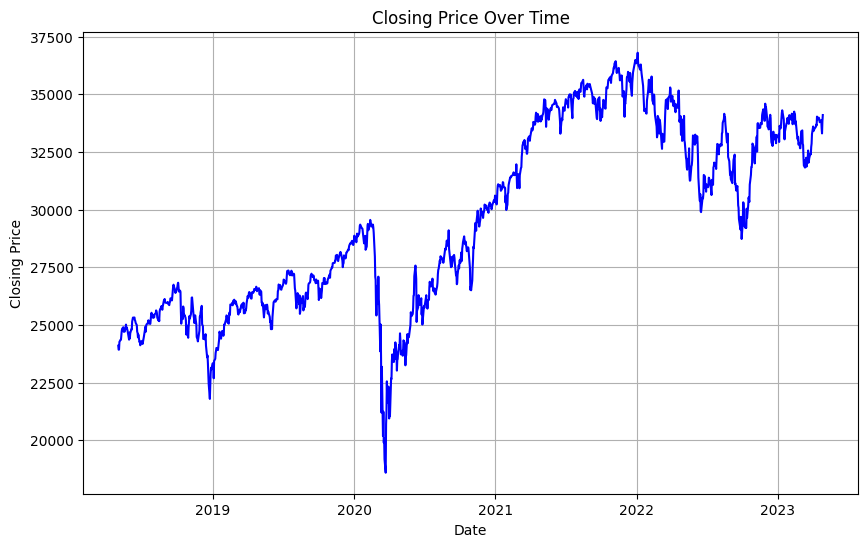

In [155]:
# Построение графика цены закрытия актива с течением времени
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close*'], color='blue')  # Using 'Close*' column
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

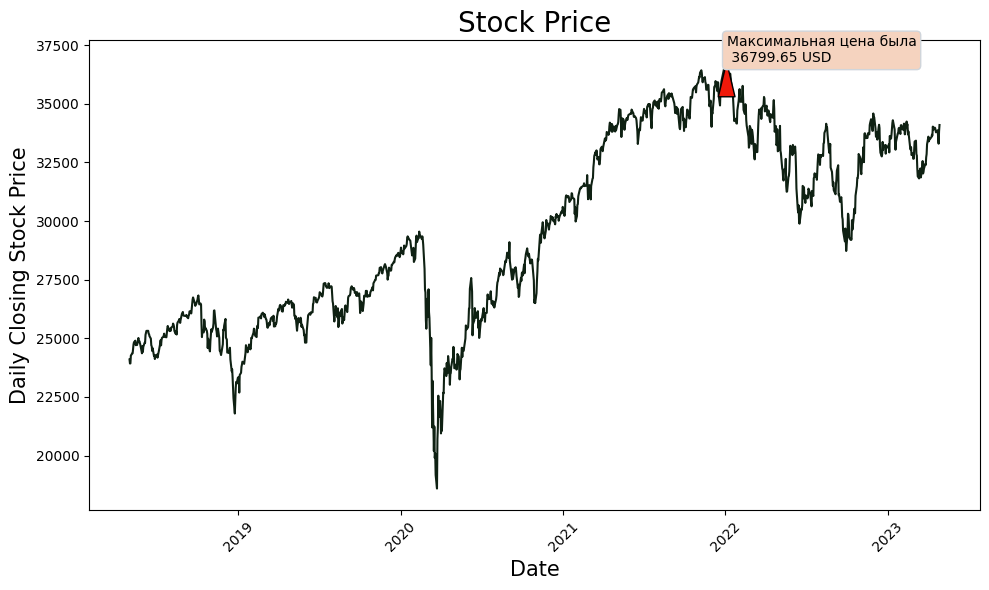

In [156]:
high = data['Close*'].max()

# Находим индекс строки с максимальным значением
max_idx = data['Close*'].idxmax()

# Извлекаем соответствующую дату
datetime = data.loc[max_idx, 'Date']
# Строим график
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['Date'], data['Close*'], color='#0f2113')
ax.set_title("Stock Price", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Daily Closing Stock Price", fontsize=15)

# Добавляем аннотацию для максимальной цены
ax.annotate(f"Максимальная цена была\n {round(high, 4)} USD",
            xy=(datetime, high),
            xytext=(datetime, high-35),
            bbox=dict(boxstyle="round", facecolor='#f5d3bf', edgecolor='#d0d5db'),
            arrowprops=dict(facecolor='#f0190a', headlength=25, shrink=0.1))

# Показать график
plt.xticks(rotation=45)  # Поворот дат на оси X для удобства
plt.tight_layout()  # Обеспечивает, чтобы аннотация не выходила за пределы
# Показать график
plt.show()

In [157]:
# Check for null values in the DataFrame
null_values = data.isnull().sum()

# Display the count of null values for each column
print(null_values)

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64


In [158]:
# Display the column names of the DataFrame
column_names = data.columns
column_names

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

# LSTM (Long Short-Term Memory)
LSTM — это тип рекуррентной нейронной сети (RNN), которая особенно полезна для анализа временных рядов. LSTM может моделировать долгосрочные зависимости в данных.

Пример для LSTM можно построить с использованием Keras или TensorFlow.

In [159]:
# Нормализовать числовые характеристики
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Adj Close**', 'Volume', 'Close*']])

# Split data into X (features) and y (target)
X = scaled_data[:, :-1]  # Входные данные (кроме 'Close*')
y = scaled_data[:, -1]   # Целевая переменная ('Close*')

# Разделение данных на обучающие и тестовые наборы
# Разделение 80% данных для обучения и оставшихся 20% для тестирования
from sklearn.model_selection import train_test_split

# 3. Разделение данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Определение модели для глубокого обучения.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# 5. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the model-обучить модель
model.fit(X_train, y_train, epochs=5, batch_size=64)

# 7. Evaluate the model
loss = model.evaluate(X_test, y_test)

# 8.Make predictions
predictions = model.predict(X_test)

# 9. Calculate R-squared
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, predictions)

#10. Calculate R-squared
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2886
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017  
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
R-squared: 0.9624105170415581


Код вычисляет коэффициент детерминации (R-квадрат) для оценки качества модели машинного обучения.

**R-квадрат (R²)** — это статистическая мера, которая показывает, насколько хорошо независимые переменные в регрессионной модели предсказывают зависимую переменную.  Другими словами, он показывает, какая доля вариации зависимой переменной объясняется независимыми переменными модели.

* **Значение R² находится в диапазоне от 0 до 1.**
* **R² = 1:** Модель идеально предсказывает зависимую переменную. Все вариации зависимой переменной объясняются независимыми переменными.
* **R² = 0:**  Модель не предсказывает зависимую переменную лучше, чем простое среднее значение зависимой переменной.  Независимые переменные не объясняют вариацию зависимой переменной.
* **0 < R² < 1:** Модель объясняет некоторую часть вариации зависимой переменной. Чем ближе R² к 1, тем лучше модель.

В предоставленном коде:

1. `from sklearn.metrics import r2_score` импортирует функцию `r2_score` из библиотеки scikit-learn, которая предназначена для вычисления R².

2. `r_squared = r2_score(y_test, predictions)` вычисляет R².  
    * `y_test` — это истинные значения зависимой переменной для тестового набора данных.
    * `predictions` — это предсказанные значения зависимой переменной, полученные с помощью вашей модели машинного обучения.

3. `print("R-squared:", r_squared)` выводит рассчитанное значение R².

**В контексте данного проекта:**  R² показывает, насколько хорошо разработанная модель предсказывает цену закрытия акций (или, в случае перехода к задаче классификации, — насколько хорошо модель предсказывает направление изменения цены).  Высокий R² указывает на то, что модель хорошо объясняет колебания цен, а низкий R² — что модель не очень точна.  Важно помнить, что высокий R² не всегда означает хорошую модель; иногда модель может быть переобучена и плохо работать на новых данных.


In [160]:
predictions = predictions.reshape(-1, 1)

# Теперь и y_test, и predictions имеют одинаковое значение.
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions.shape)

Shape of y_test: (252,)
Shape of predictions: (252, 1)


In [161]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.0016889016324303733
Root Mean Squared Error (RMSE): 0.04109624839848977


В данном коде рассчитываются два важных показателя для оценки качества модели машинного обучения: **Среднеквадратичная ошибка (MSE)** и **Корень из среднеквадратичной ошибки (RMSE)**.

1. **Среднеквадратичная ошибка (MSE - Mean Squared Error)** — это метрика, которая измеряет среднее значение квадрата ошибок между предсказанными значениями модели и фактическими значениями. Чем меньше значение MSE, тем лучше модель предсказывает данные, так как ошибка в прогнозах минимальна.

   В коде MSE рассчитывается с помощью функции `mean_squared_error(y_test, predictions)`, где `y_test` — это реальные значения, а `predictions` — предсказания модели.

2. **Корень из среднеквадратичной ошибки (RMSE - Root Mean Squared Error)** — это просто квадратный корень из значения MSE. RMSE возвращает ошибку в тех же единицах измерения, что и исходные данные, что делает его более интерпретируемым в контексте реальных значений. Чем меньше RMSE, тем точнее модель.
В коде RMSE рассчитывается с помощью функции `np.sqrt(mse)`, где `mse` — это уже вычисленное значение среднеквадратичной ошибки.

### Зачем используются MSE и RMSE:
- **MSE** используется для того, чтобы понять, насколько сильно предсказания модели отклоняются от реальных значений.
- **RMSE** дает более наглядное представление об ошибке, так как результат выражен в тех же единицах измерения, что и исходные данные, что упрощает интерпретацию.

В нашем случае значения MSE и RMSE указывают на хорошую производительность модели.

In [162]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_test, predictions)

print("R-squared:", r_squared)

R-squared: 0.9624105170415581


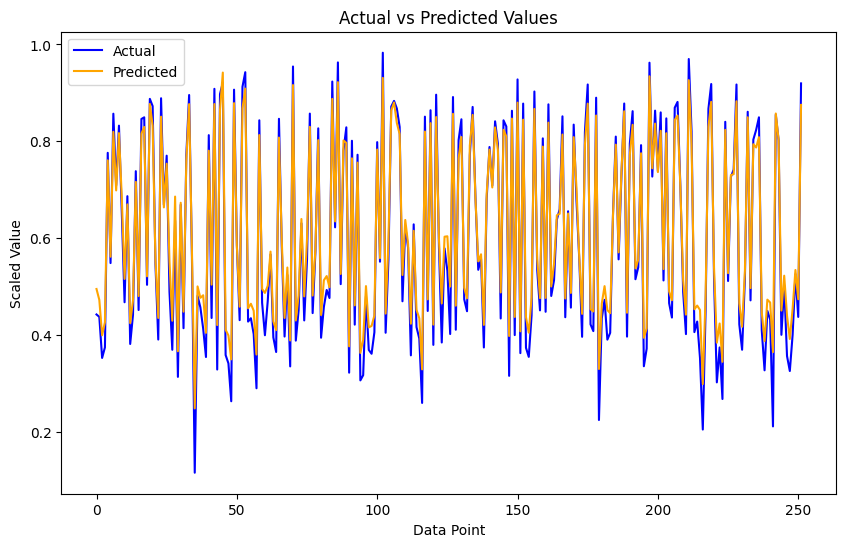

In [163]:
# Plotting real vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Scaled Value')  # Remember, you're working with scaled values
plt.legend()
plt.show()

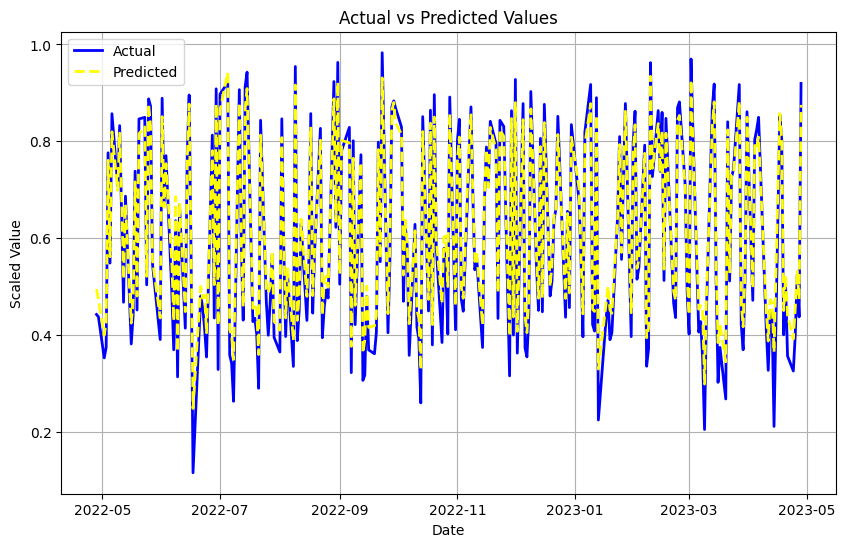

In [164]:
# Plotting real vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][len(X_train):], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(data['Date'][len(X_train):], predictions, label='Predicted', color='yellow', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Scaled Value')  # Remember, you're working with scaled values
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [165]:
data.set_index('Date', inplace=True)

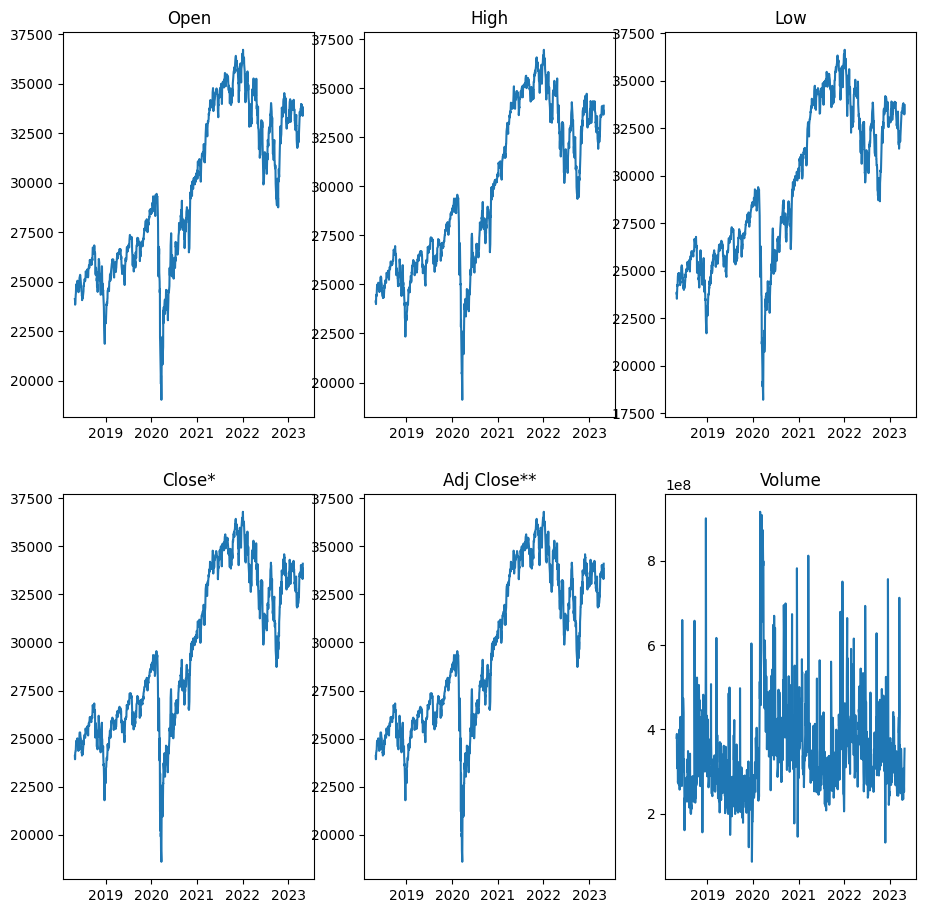

In [166]:
fig = plt.figure(figsize=(11,11))
i=1
for x in data.columns :
    plt.subplot(2,3,i)
    ax=sns.lineplot(data[x])
    ax.set(xlabel=None)
    plt.title(str(x), loc='center')
    plt.xlabel(None)
    plt.ylabel(None)
    i+=1
plt.show()

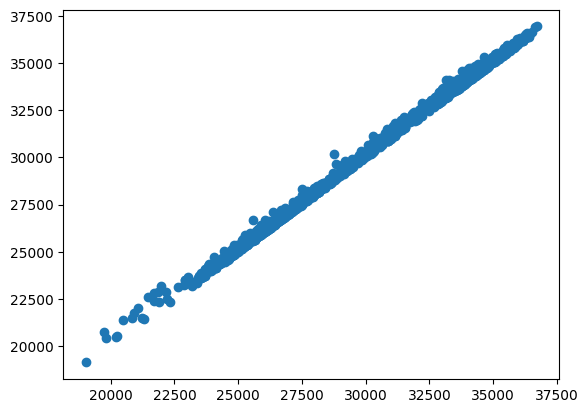

In [167]:
plt.scatter(data=data,x="Open",y="High")

Точки на графике сгруппированы вдоль прямой, и по мере роста цены открытия (Open) растет и максимальная цена (High), это может означать, что существует положительная зависимость между этими двумя переменными.

### **ARIMA**:

**ARIMA** (AutoRegressive Integrated Moving Average) — это популярная модель для анализа и прогнозирования временных рядов. Она применяется, когда данные показывают зависимость от предыдущих значений и (или) требуют удаления трендов или сезонности.

**ARIMA состоит из трех частей**:
1. **AR (AutoRegressive - Авторегрессия)**: Модель использует линейную зависимость между текущим значением и его предыдущими значениями (лагами).
2. **I (Integrated - Интегрированное)**: Преобразование данных, чтобы сделать их стационарными, то есть удалить тренды и сезонные колебания. Это делается с помощью дифференцирования данных.
3. **MA (Moving Average - Скользящее среднее)**: Модель использует ошибку предыдущих предсказаний (ошибки модели) для корректировки текущего прогноза.

### Важные моменты при использовании ARIMA:
- Модель ARIMA подходит для **стационарных** временных рядов, то есть таких, у которых статистические свойства (среднее, дисперсия) не меняются со временем.
- Перед применением модели ARIMA часто проводят **дифференцирование** данных, чтобы убрать тренды и сделать ряд стационарным.
- Параметры модели (AR, I, MA) должны быть настроены для конкретного набора данных. Параметры выбираются с помощью различных методов, таких как анализ автокорреляции и частичной автокорреляции, или с использованием методов оптимизации.

### Пример применения:
- В данном коде модель ARIMA используется для прогнозирования **цен закрытия акций**. Она будет предсказывать, как будут изменяться цены на основе исторических данных о цене закрытия.

Этот метод широко используется в экономике, финансах, маркетинге и других областях для прогнозирования временных рядов, таких как валютные курсы, объемы продаж или цены на акции.

Данный код создает модель **ARIMA** для прогнозирования цен закрытия акций с использованием временных рядов. Он обучает модель на исторических данных и прогнозирует будущие значения на несколько дней вперед.

### Описание шагов кода:

1. **`arima_data = data['Close*']`**:
   - Из датафрейма `data` выбирается столбец **"Close*"**, который содержит данные о цене закрытия актива. Эти данные будут использоваться для построения модели ARIMA.

2. **`arima_model = ARIMA(arima_data, order=(5, 1, 0))`**:
   - Создается объект модели **ARIMA**. Здесь:
     - **`order=(5, 1, 0)`** — это параметры модели ARIMA:
       - **5** — количество лагов для авторегрессии (AR, AutoRegressive), то есть, сколько предыдущих значений используется для прогнозирования.
       - **1** — степень дифференцирования (I, Integrated), которая помогает сделать временной ряд стационарным, устраняя тренды или сезонность.
       - **0** — количество лагов для скользящего среднего (MA, Moving Average), то есть, сколько предыдущих ошибок модели используется для прогнозирования.
   
3. **`arima_fit = arima_model.fit()`**:
   - Модель ARIMA обучается на исторических данных о цене закрытия с использованием метода **fit()**. Это шаг, в котором модель оценивает параметры (веса) для соответствия данным.

4. **`arima_forecast = arima_fit.forecast(steps=10)`**:
   - Прогнозируются следующие 10 значений на основе обученной модели ARIMA с использованием метода **forecast()**. Это предсказание будущих цен закрытия.

5. **`plt.figure(figsize=(10, 6))`**:
   - Создается фигура графика размером 10x6 дюймов.

6. **`plt.plot(data.index[-100:], data['Close*'][-100:], label='Исторические данные')`**:
   - На графике отображаются последние 100 значений **исторических данных** (цены закрытия), используя даты как ось X.

7. **`future_dates = pd.date_range(data.index[-1], periods=10, freq='B')`**:
   - Генерируются будущие даты, которые будут использоваться для прогнозирования. `periods=10` означает, что генерируется 10 дней, а `freq='B'` указывает на то, что даты будут рабочими днями (исключаются выходные).




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

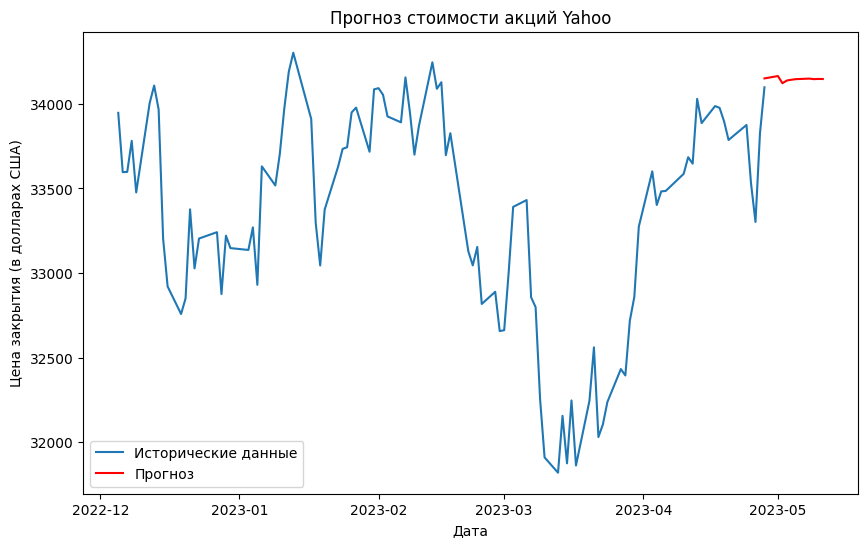

In [168]:
# Базовая модель: ARIMA
arima_data = data['Close*']
arima_model = ARIMA(arima_data, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Прогнозирование с помощью ARIMA
arima_forecast = arima_fit.forecast(steps=10)
plt.figure(figsize=(10, 6))
plt.plot(data.index[-100:], data['Close*'][-100:], label='Исторические данные')  # Даты на оси X
future_dates = pd.date_range(data.index[-1], periods=10, freq='B')  # Будущие даты
plt.plot(future_dates, arima_forecast, label='Прогноз', color='red')  # Прогноз с будущими датами
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (в долларах США)')
plt.title('Прогноз стоимости акций Yahoo')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

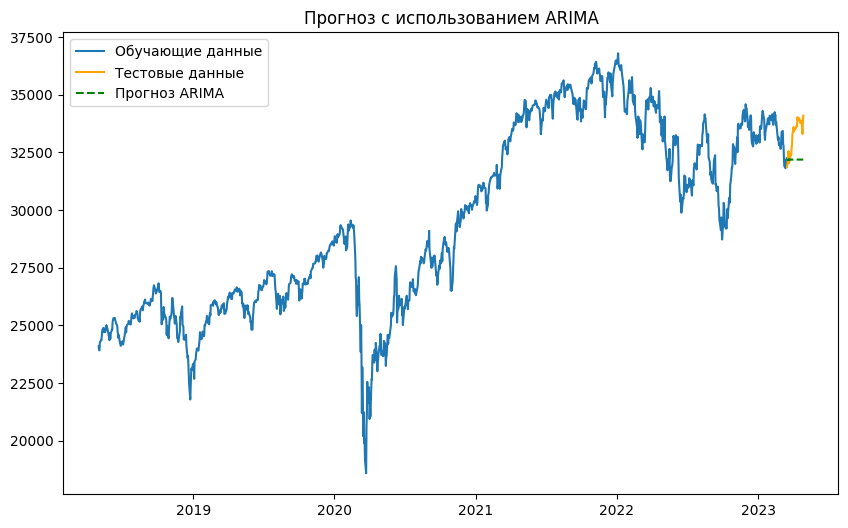

In [169]:

# ARIMA: Подготовка данных
train = data['Close*'][:-30]  # Используем все данные, кроме последних 30 для тестирования
test = data['Close*'][-30:]   # Последние 30 данных - для теста

# Обучаем модель ARIMA
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Прогнозируем
forecast_arima = model_arima_fit.forecast(steps=30)

# Визуализация результатов
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Обучающие данные')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(test.index, forecast_arima, label='Прогноз ARIMA', color='green', linestyle='--')
plt.title('Прогноз с использованием ARIMA')
plt.legend()
plt.show()


1. Вычисление доходности (Return):

```
data['Return'] = data['Close*'].pct_change()

```
pct_change() — это метод, который рассчитывает доходность для каждого периода,
используя разницу между текущим и предыдущим значением. Доходность показывает, на сколько изменился курс акции по сравнению с предыдущим днем.
Столбец "Return" будет содержать процентное изменение в цене закрытия акции с одного дня на следующий.

2. Вычисление волатильности (Volatility):


```
data['Volatility'] = data['Close*'].rolling(window=5).std()
```

rolling(window=5) — метод, который создает "скользящее окно" длиной в 5 дней, то есть для каждого дня он будет учитывать текущий день и предыдущие 4 дня.
std() — вычисляет стандартное отклонение для каждого скользящего окна. Стандартное отклонение измеряет волатильность: чем выше значение, тем более волатильна (непредсказуема) цена акции.
Столбец "Volatility" будет содержать волатильность за последние 5 дней для каждого дня в данных.

3. Вычисление скользящей средней (SMA_10):



```
data['SMA_10'] = data['Close*'].rolling(window=10).mean()
```
rolling(window=10) — метод для создания скользящего окна длиной в 10 дней.
mean() — вычисляет среднее значение для каждого скользящего окна из 10 дней.
Столбец "SMA_10" будет содержать 10-дневную скользящую среднюю цены закрытия. Это помогает сгладить данные и увидеть общий тренд на более долгосрочную перспективу.

4. Создание целевой переменной (Target):


```
data['Target'] = np.where(data['Close*'].shift(-1) > data['Close*'], 1, 0)
```
shift(-1) — сдвигает данные на один день вперед, то есть для каждого дня смотрим, выше ли цена закрытия следующего дня (сдвинутого на один) по сравнению с текущим днем.
np.where(..., 1, 0) — создает бинарную переменную:
Если цена закрытия следующего дня выше текущей, то целевая переменная "Target" будет равна 1 (то есть модель предполагает, что цена вырастет).

Если цена не растет (меньше или равна), то "Target" будет равна 0 (модель предполагает, что цена не вырастет).

Таким образом, целевая переменная "Target" будет бинарной, и она представляет собой задачу для бинарной классификации (повысится ли цена на следующий день или нет).



In [174]:
data['Return'] = data['Close*'].pct_change()

data['Volatility'] = data['Close*'].rolling(window=5).std()
data['SMA_10'] = data['Close*'].rolling(window=10).mean()
data['Target'] = np.where(data['Close*'].shift(-1) > data['Close*'], 1, 0)

# Удаление строк с пропущенными значениями
data.dropna(inplace=True)

# Разделение данных на обучающую и тестовую выборки
features = ['Return', 'Volatility', 'SMA_10']
X = data[features]
y = data['Target']
# Разделение данных на обучающую и тестовую выборки:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
data['Target'].describe()

,Target
count,1240.000000
mean,0.540323
std,0.498573
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# GradientBoostingClassifier
GradientBoostingClassifier — это модель, основанная на методе градиентного бустинга, который является мощным алгоритмом для классификации и регрессии. Градиентный бустинг работает, комбинируя несколько слабых моделей (обычно деревьев решений), чтобы построить более сильную модель.

* n_estimators=100 — количество базовых моделей (деревьев решений), которые будут обучаться. Здесь используется 100 деревьев.
* learning_rate=0.1 — скорость обучения (или шаг), которая контролирует вклад каждой модели в итоговый результат. Низкая скорость обучения обычно означает более точную, но медленную сходимость.

roc_auc_score(y_test, y_prob_gr) — вычисление ROC-AUC (Receiver Operating Characteristic - Area Under Curve).
Это метрика, которая измеряет способность модели различать классы. Чем ближе значение к 1, тем лучше модель. ROC-AUC считается одним из лучших показателей для оценки бинарных классификаторов, особенно когда классы несбалансированы.

В нашем случае результат не очень хороший нужна ещё работать над моделью.

**classification_report(y_test, y_pred_gr)** — выводит подробный классификационный отчет, включая такие метрики, как:
* Precision (точность): доля правильных положительных предсказаний среди всех предсказанных положительных.
* Recall (полнота): доля правильно предсказанных положительных среди всех реальных положительных.
* F1-score: гармоническое среднее между точностью и полнотой, которое дает более сбалансированное представление о качестве модели.
* Support: количество экземпляров каждого класса.

In [176]:
# Инициализация модели
model_gr = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

# Обучение модели
model_gr.fit(X_train, y_train)

# Предсказания
y_pred_gr = model_gr.predict(X_test)
y_prob_gr = model_gr.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# 1. ROC-AUC
roc_auc_gr = roc_auc_score(y_test, y_prob_gr)
print(f"ROC-AUC: {roc_auc_gr}")
# Оценка точности
print(f"Точность: {accuracy_score(y_test, y_pred_gr)}")
print("Классификационный отчет:\n", classification_report(y_test, y_pred_gr))
mse = mean_squared_error(y_test, y_pred_gr)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

ROC-AUC: 0.47086953593318515
Точность: 0.5161290322580645
Классификационный отчет:
               precision    recall  f1-score   support

           0       0.37      0.28      0.32       101
           1       0.58      0.68      0.62       147

    accuracy                           0.52       248
   macro avg       0.48      0.48      0.47       248
weighted avg       0.49      0.52      0.50       248

Mean Squared Error (MSE): 0.4838709677419355
Root Mean Squared Error (RMSE): 0.6956083436402524


**Матрица ошибок** — это таблица, которая показывает, как хорошо модель классифицировала примеры, сравнивая предсказанные значения с истинными метками.

Матрица ошибок будет выглядеть следующим образом:

Этот код реализует построение и отображение **матрицы ошибок** (confusion matrix) для модели классификации, используя библиотеку **Seaborn** для визуализации. Давайте разберем каждую часть кода:

### 1. **Создание матрицы ошибок**:
```python
conf_matrix = confusion_matrix(y_test, y_pred_gr)
```
- **`confusion_matrix(y_test, y_pred_gr)`** — это функция из библиотеки **scikit-learn**, которая вычисляет **матрицу ошибок**. Матрица ошибок — это таблица, которая показывает, как хорошо модель классифицировала примеры, сравнивая предсказанные значения с истинными метками.
  - **`y_test`** — это настоящие (истинные) метки классов для тестовых данных.
  - **`y_pred_gr`** — это предсказанные моделью метки классов для тестовых данных.

Матрица ошибок будет выглядеть следующим образом:

|                | Predicted Negative | Predicted Positive |
|----------------|--------------------|--------------------|
| **Actual Negative** | True Negative (TN)  | False Positive (FP)  |
| **Actual Positive** | False Negative (FN) | True Positive (TP)   |

- **True Negative (TN)**: правильное предсказание отрицательного класса.
- **False Positive (FP)**: неправильное предсказание положительного класса (ошибка типа I).
- **False Negative (FN)**: неправильное предсказание отрицательного класса (ошибка типа II).
- **True Positive (TP)**: правильное предсказание положительного класса.



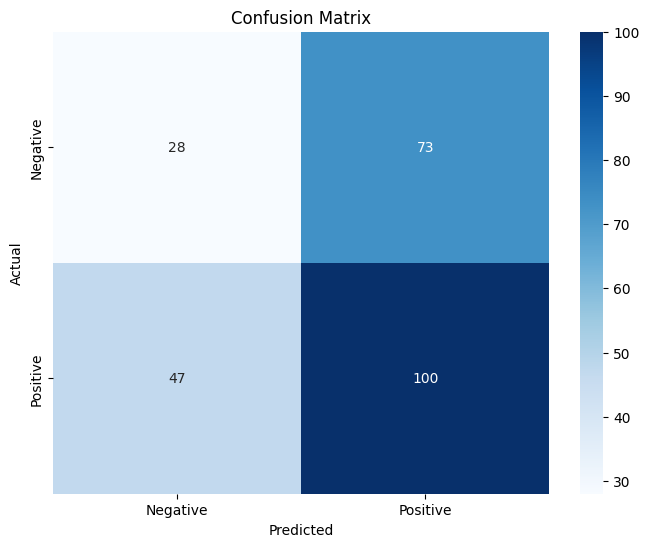

In [177]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gr)

# Отображаем confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# XGBClassifier

In [179]:
# Инициализация модели
model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1)

# Обучение модели
model_xgb.fit(X_train, y_train)

# Предсказания
y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# 1. ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"ROC-AUC: {roc_auc_xgb}")
# Оценка точности
print(f"Точность: {accuracy_score(y_test, y_pred_xgb)}")

mse = mean_squared_error(y_test, y_pred_xgb)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Классификационный отчет:\n", classification_report(y_test, y_pred_xgb))

ROC-AUC: 0.5027951774769313
Точность: 0.5161290322580645
Mean Squared Error (MSE): 0.4838709677419355
Root Mean Squared Error (RMSE): 0.6956083436402524
Классификационный отчет:
               precision    recall  f1-score   support

           0       0.41      0.44      0.42       101
           1       0.60      0.57      0.58       147

    accuracy                           0.52       248
   macro avg       0.50      0.50      0.50       248
weighted avg       0.52      0.52      0.52       248



# RandomForestClassifier

In [181]:
# Обучаем модель
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Прогнозируем на тестовых данных
y_pred_rf = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# 1. ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc}")
# Оценка модели
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Точность модели RandomForest: {accuracy_rf:.4f}")

mse = mean_squared_error(y_test, y_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

print("Классификационный отчет:\n", classification_report(y_test, y_pred_rf))

ROC-AUC: 0.49929278642149927
Точность модели RandomForest: 0.4960
Mean Squared Error (MSE): 0.5040322580645161
Root Mean Squared Error (RMSE): 0.709952292808831
Классификационный отчет:
               precision    recall  f1-score   support

           0       0.40      0.47      0.43       101
           1       0.58      0.52      0.55       147

    accuracy                           0.50       248
   macro avg       0.49      0.49      0.49       248
weighted avg       0.51      0.50      0.50       248



**ROC-AUC** - измеряет способность модели различать два класса. Это площадь под кривой ROC, которая отображает соотношение между чувствительностью (true positive rate) и специфичностью (false positive rate).

Преимущества: Хорошо работает при несбалансированных данных.

ROC-AUC:

Мы используем roc_auc_score для вычисления значения ROC-AUC. Оно показывает способность модели различать классы. Чем выше значение, тем лучше модель.
Строим ROC-кривую с помощью roc_curve и визуализируем ее.

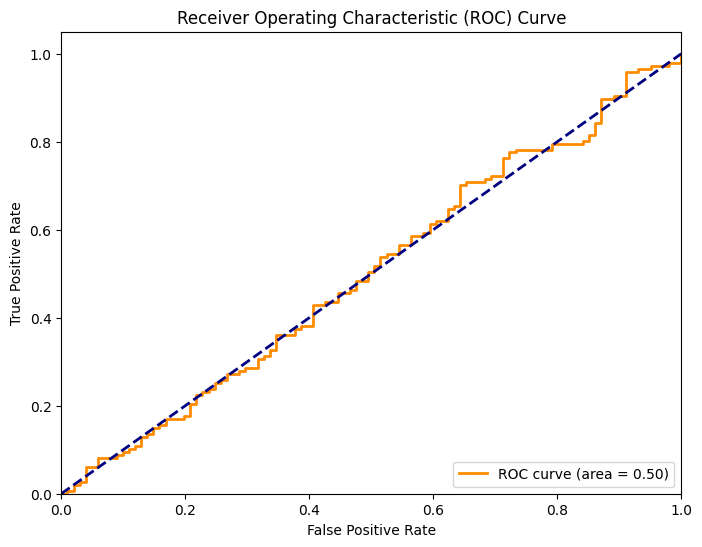

In [182]:
# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

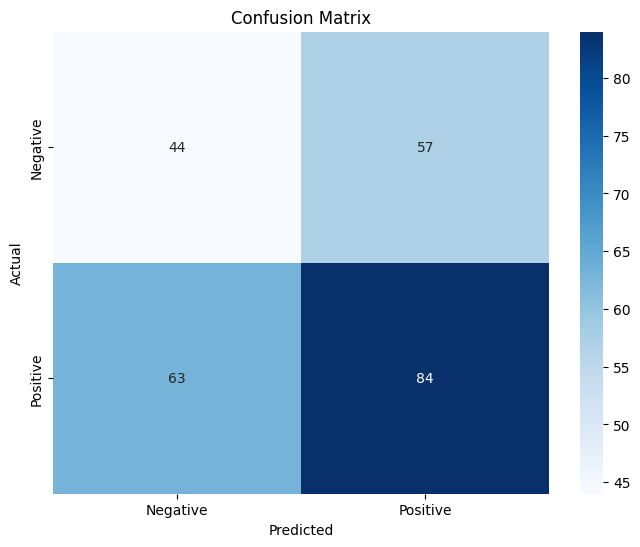

In [183]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Отображаем confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [184]:
y_pred_xgb = y_pred_xgb.reshape(-1, 1)

print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_xgb:", y_pred_xgb.shape)

Shape of y_test: (248,)
Shape of y_pred_xgb: (248, 1)


In [185]:
# Сравним длину реальных значений и предсказаний
print("Длина y_test:", len(y_test))
print("Длина y_prob_xgb:", len(y_pred_xgb))

# Проверим индексы
print("Индексы y_test:", y_test.index[:5])
print("Первые 5 индексов для предсказаний:", X_test.index[:5])


Длина y_test: 248
Длина y_prob_xgb: 248
Индексы y_test: DatetimeIndex(['2020-01-21', '2019-06-07', '2019-09-20', '2020-11-12',
               '2018-10-18'],
              dtype='datetime64[ns]', name='Date', freq=None)
Первые 5 индексов для предсказаний: DatetimeIndex(['2020-01-21', '2019-06-07', '2019-09-20', '2020-11-12',
               '2018-10-18'],
              dtype='datetime64[ns]', name='Date', freq=None)


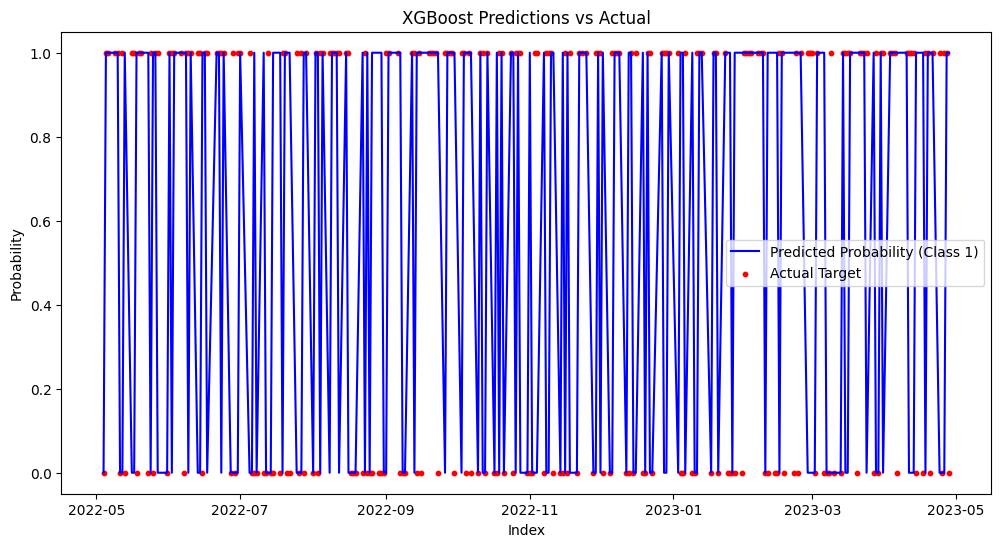

In [186]:
# Построение графика
plt.figure(figsize=(12, 6))

# Отображение вероятностей предсказаний
plt.plot(data.index[-len(y_test):], y_pred_xgb, label='Predicted Probability (Class 1)', color='blue')

# Реальные метки классов
plt.scatter(data.index[-len(y_test):], y_test, color='red', label='Actual Target', s=10)

plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [187]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close*']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close*']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close*']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close*'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close*'])
    plt.plot(valid_set[['Close*', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (930, 1)
Shape of Validation Set (310, 1)
RMSE value on validation set: 4036.743889536651
-----------------------------------------------------------
-----------------------------------------------------------


<ipython-input-187-3cf91fb8b109>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set['Predictions'] = preds


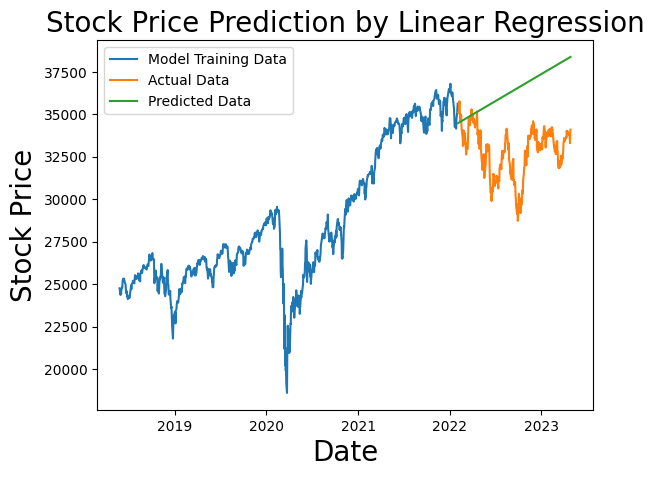

In [188]:
linear_regression_prediction(data)

In [189]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close*']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close*']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close*']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close*'])
    plt.plot(valid_set[['Close*', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (930, 1)
Shape of Validation Set (310, 1)
RMSE value on validation set: 5762.082797060782
-----------------------------------------------------------
-----------------------------------------------------------


<ipython-input-189-04dc86538f3e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set['Predictions'] = preds


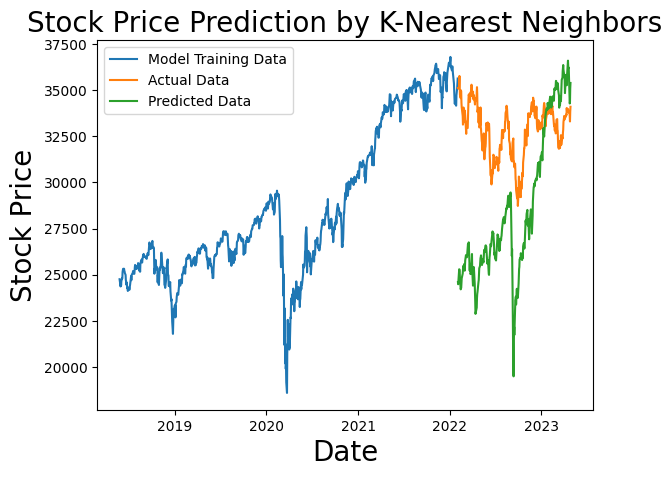

In [190]:
k_nearest_neighbours_predict(data)